In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.3 MB/s eta

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
train_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/ta-misogyny-train.csv",header=None,sep='\t')
validation_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/ta-misogyny-dev.csv",header=None,sep='\t')
test_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/tamil_test_with_labels.csv", header=None)
prediction_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/tamil_test_without_labels.csv", header=None)
stopwords = pd.read_csv('/content/gdrive/MyDrive/TamilNLP/TamilStopWords.txt', header=None, names=['Tamil Stop Words'])
print(f"Training data : {train_set.shape} \nValidation data : {validation_set.shape} \nTest data : {test_set.shape} \nPrediction data : {prediction_set.shape}")

Training data : (2240, 2) 
Validation data : (560, 2) 
Test data : (699, 2) 
Prediction data : (699, 1)


In [ ]:
def modify_dataset(df):
  df.rename(columns={0:'Label', 1:'Text'}, inplace=True)
  df = df[['Text', 'Label']]
  return df
train_set = modify_dataset(train_set)
validation_set = modify_dataset(validation_set)
test_set = modify_dataset(test_set)
prediction_set = prediction_set.rename(columns={0:'Text'})

None-of-the-above    1296
Misandry              446
Counter-speech        149
Misogyny              125
Xenophobia             95
Hope-Speech            86
Homophobia             35
Transphobic             6
Not-Tamil               2
Name: Label, dtype: int64


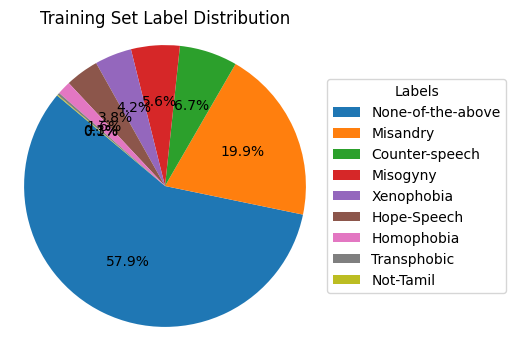

In [ ]:
category_counts = train_set['Label'].value_counts()
print(category_counts)
plt.figure(figsize=(4, 4))
wedges, labels, autopct = plt.pie(category_counts, autopct='%1.1f%%', startangle=140)
plt.legend(wedges, category_counts.index, title='Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Training Set Label Distribution')
plt.axis('equal')
plt.show()

In [ ]:
num_labels = len(train_set['Label'].unique())
keys = list(train_set['Label'].unique())
values = list(range(0, num_labels))
label_dict = dict(zip(keys,values))
train_set['Label'] = train_set['Label'].apply(lambda x:label_dict[x])
test_set['Label'] = test_set['Label'].apply(lambda x:label_dict[x])
validation_set['Label'] = validation_set['Label'].apply(lambda x:label_dict[x])
label_dict

{'Hope-Speech': 0,
 'None-of-the-above': 1,
 'Homophobia': 2,
 'Misandry': 3,
 'Counter-speech': 4,
 'Misogyny': 5,
 'Xenophobia': 6,
 'Transphobic': 7,
 'Not-Tamil': 8}

In [ ]:
tamil_stopwords = set(stopwords['Tamil Stop Words'])

In [ ]:
# Function to remove Tamil stopwords from a given text
def remove_tamil_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in tamil_stopwords]
    return ' '.join(filtered_words)

# Apply the remove_tamil_stopwords function to the "Text" column in all datasets
train_set['Text'] = train_set['Text'].apply(remove_tamil_stopwords)
validation_set['Text'] = validation_set['Text'].apply(remove_tamil_stopwords)
test_set['Text'] = test_set['Text'].apply(remove_tamil_stopwords)
prediction_set['Text'] = prediction_set['Text'].apply(remove_tamil_stopwords)

# Print the shapes of the datasets to confirm the changes
print(f"Training data : {train_set.shape} \nValidation data : {validation_set.shape} \nTest data : {test_set.shape} \nPrediction data : {prediction_set.shape}")

Training data : (2240, 2) 
Validation data : (560, 2) 
Test data : (699, 2) 
Prediction data : (699, 1)


In [ ]:
def oversample(df):
      classes = df['Label'].value_counts().to_dict()
      most = max(classes.values())
      classes_list = []
      for key in classes:
          classes_list.append(df[df['Label'] == key])
      classes_sample = []
      for i in range(1,len(classes_list)):
          classes_sample.append(classes_list[i].sample(most, replace=True))
      df_maybe = pd.concat(classes_sample)
      final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
      final_df = final_df.reset_index(drop=True)
      return pd.DataFrame({'Text': final_df['Text'].tolist(), 'Label': final_df['Label'].tolist()})

In [ ]:
def over_under_sample(df):
  unq_labels = list(set(df['Label'].tolist()))
  texts = df['Text'].tolist()
  labels = df['Label'].tolist()
  data_dict = dict()

  for l in unq_labels:
    data_dict[l] = []

  for i in range(len(texts)):
    data_dict[labels[i]].append(texts[i])

  req_len = len(labels)//len(unq_labels)

  for label in data_dict:
    if len(data_dict[label]) > req_len:
      data_dict[label] = data_dict[label][:req_len]

    new_texts = []

    new_labels = []
    for l in data_dict:
      new_texts += data_dict[l]
      new_labels += [l]*len(data_dict[l])
    return oversample(pd.DataFrame({'Text': new_texts, 'Label': new_labels}))

In [ ]:
training_set = over_under_sample(train_set)

In [ ]:
epochs=3
model_args = ClassificationArgs()
model_args.overwrite_output_dir=True
model_args.eval_batch_size=8
model_args.train_batch_size=32
model_args.learning_rate=4e-5

In [ ]:
model = ClassificationModel(
    'bert',
    'google/muril-base-cased',
    num_labels=9,
    args=model_args,
    use_cuda=True,
    tokenizer_type="bert",
    tokenizer_name='google/muril-base-cased'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses = []
train_accuracies = []

for i in range(epochs):
    model.train_model(training_set,eval_data=validation_set,acc=sklearn.metrics.classification_report)
    result, model_outputs, preds_list = model.eval_model(test_set,acc=sklearn.metrics.classification_report)
    print(preds_list, model_outputs)
    for j in result.values():
        print(j)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11664 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/365 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

[{'guid': 1, 'text_a': 'வந்தேரிக்கு தகுந்த பாடம் கற்பிப்பார்கள் தமிழர்கள்.', 'text_b': None, 'label': 6}, {'guid': 4, 'text_a': 'சக தோழியாக நினைத்து ஆதரவு தாருங்கள் நண்பர்களே!!!! பயனுள்ள வகையில் தகவல்களைபதிவிடுகிறேனன் பார்த்து ஆதரவு தாருங்கள்...', 'text_b': None, 'label': 1}, {'guid': 5, 'text_a': 'நல்ல கருத்துக்களை சொன்ன திருவள்ளுவர் கணவன் மனைவி பேச்சைக் கேட்டு நடக்கக்கூடாது.... அப்படி நடந்தால் வாழ்க்கை சீரழிந்துவிடும் எழுதி இருப்பது வருத்தமளிக்கிறது.', 'text_b': None, 'label': 1}, {'guid': 6, 'text_a': 'சூத்திர பொட்ட ஜாதிவெறி புண்டை சூத்திர கும்பல் ஆப்பிரிக்கா வில் வந்தது....சாணிக்கும்', 'text_b': None, 'label': 6}, {'guid': 7, 'text_a': '+பிரபல நாட்டாமை 8 க்கு இருக்கு', 'text_b': None, 'label': 1}, {'guid': 8, 'text_a': 'Fathima.yashin Shakh துலுக்க புண்டை...', 'text_b': None, 'label': 6}, {'guid': 9, 'text_a': 'எதற்க்கு எடுத்தாலும் எடுத்தெரிந்து பேசும் மனைவியிடம் எப்படி குடும்பம் நடத்துவது?', 'text_b': None, 'label': 1}, {'guid': 10, 'text_a': 'சாதி வெறி காட்டுமிராண்டி நாய்ங்க எவன்

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/simpletransformers/class

  0%|          | 0/11664 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/365 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

[{'guid': 0, 'text_a': 'தமிழன் சாதிவெறி', 'text_b': None, 'label': 6}, {'guid': 1, 'text_a': 'வந்தேரிக்கு தகுந்த பாடம் கற்பிப்பார்கள் தமிழர்கள்.', 'text_b': None, 'label': 6}, {'guid': 4, 'text_a': 'சக தோழியாக நினைத்து ஆதரவு தாருங்கள் நண்பர்களே!!!! பயனுள்ள வகையில் தகவல்களைபதிவிடுகிறேனன் பார்த்து ஆதரவு தாருங்கள்...', 'text_b': None, 'label': 1}, {'guid': 5, 'text_a': 'நல்ல கருத்துக்களை சொன்ன திருவள்ளுவர் கணவன் மனைவி பேச்சைக் கேட்டு நடக்கக்கூடாது.... அப்படி நடந்தால் வாழ்க்கை சீரழிந்துவிடும் எழுதி இருப்பது வருத்தமளிக்கிறது.', 'text_b': None, 'label': 1}, {'guid': 8, 'text_a': 'Fathima.yashin Shakh துலுக்க புண்டை...', 'text_b': None, 'label': 6}, {'guid': 10, 'text_a': 'சாதி வெறி காட்டுமிராண்டி நாய்ங்க எவன்', 'text_b': None, 'label': 1}, {'guid': 11, 'text_a': 'எச் ராஜா பெண்', 'text_b': None, 'label': 7}, {'guid': 21, 'text_a': 'வரதட்சணை கேட்கும் பெண்கள் பெற்றோரின் துன்பத்திலும் இன்பத்திலும் துணை நிற்பேன் யாரும் பேசுவது இல்லை பெற்றோர் வாங்கிய கடனை அடைக்க உதவி செய்வோம் யாரும் சொல்லவில்லை மொ

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/simpletransformers/class

  0%|          | 0/11664 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/365 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

[{'guid': 0, 'text_a': 'தமிழன் சாதிவெறி', 'text_b': None, 'label': 6}, {'guid': 1, 'text_a': 'வந்தேரிக்கு தகுந்த பாடம் கற்பிப்பார்கள் தமிழர்கள்.', 'text_b': None, 'label': 6}, {'guid': 5, 'text_a': 'நல்ல கருத்துக்களை சொன்ன திருவள்ளுவர் கணவன் மனைவி பேச்சைக் கேட்டு நடக்கக்கூடாது.... அப்படி நடந்தால் வாழ்க்கை சீரழிந்துவிடும் எழுதி இருப்பது வருத்தமளிக்கிறது.', 'text_b': None, 'label': 1}, {'guid': 6, 'text_a': 'சூத்திர பொட்ட ஜாதிவெறி புண்டை சூத்திர கும்பல் ஆப்பிரிக்கா வில் வந்தது....சாணிக்கும்', 'text_b': None, 'label': 6}, {'guid': 8, 'text_a': 'Fathima.yashin Shakh துலுக்க புண்டை...', 'text_b': None, 'label': 6}, {'guid': 10, 'text_a': 'சாதி வெறி காட்டுமிராண்டி நாய்ங்க எவன்', 'text_b': None, 'label': 1}, {'guid': 11, 'text_a': 'எச் ராஜா பெண்', 'text_b': None, 'label': 7}, {'guid': 21, 'text_a': 'வரதட்சணை கேட்கும் பெண்கள் பெற்றோரின் துன்பத்திலும் இன்பத்திலும் துணை நிற்பேன் யாரும் பேசுவது இல்லை பெற்றோர் வாங்கிய கடனை அடைக்க உதவி செய்வோம் யாரும் சொல்லவில்லை மொத்தத்தில் பெற்றோர் உழைப்பில் வாழ 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
